Librerias

In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os


In [2]:
import pickle
import sys
from pathlib import Path

# Añadir el directorio raíz del proyecto a sys.path
module_path = Path('/Users/Cesar/Desktop/Proyecto-CSG/').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# Añadir el directorio que contiene 'new_spectral_metric' a sys.path
new_spectral_metric_path = module_path / '/Users/Cesar/Desktop/Proyecto-CSG/new_spectral_metric/'
if new_spectral_metric_path not in sys.path:
    sys.path.append(str(new_spectral_metric_path))

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from new_spectral_metric.new_estimator import CumulativeGradientEstimator
from new_spectral_metric.new_visualize import make_graph
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path


Lectura del dataset

In [3]:
# Lectura de dataset

directorio_dataset = ('../Datasets/CIFAR-10')
directorio_dataset = pathlib.Path(directorio_dataset)

# Lectura de la carpeta train
directorio_train = ('../Datasets/CIFAR-10/train')
directorio_train = pathlib.Path(directorio_train)

# Lectura de la carpeta test
directorio_test = ('../Datasets/CIFAR-10/test')
directorio_test = pathlib.Path(directorio_test)


total_dataset = len(list(directorio_dataset.glob('*/*/*.png')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_train = len(list(directorio_train.glob('*/*.png')))  # Cuenta la cantidad de imagenes de train
total_test = len(list(directorio_test.glob('*/*.png')))  # Cuenta la cantidad de imagenes de test

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes train: {total_train}")
print(f"Total imagenes test: {total_test}")

Total imagenes dataset: 697
Total imagenes train: 557
Total imagenes test: 140


In [4]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = 32
batch_size = total_train

In [5]:

# Data splitting (entrenamiento y validación)
all_images_in_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  #directorio_dataset,
  directorio_train,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 557 files belonging to 2 classes.


In [6]:
# Contar el total de imágenes por clase en train y test
class_counts_total = {p.name: len(list(p.glob('*.png'))) for p in directorio_dataset.glob('*/*')}
class_counts_train = {p.name: len(list(p.glob('*.png'))) for p in directorio_train.glob('*')}
class_counts_test = {p.name: len(list(p.glob('*.png'))) for p in directorio_test.glob('*')}




# Mostrar el total de imágenes por clase en train
print("\nTotal de imágenes por clase en train:")
for class_name, count in class_counts_train.items():
    print(f"Clase: {class_name}, Número de imágenes: {count}")
print(f"Total imagenes train: {total_train}")

# Mostrar el total de imágenes por clase en test
print("\nTotal de imágenes por clase en test:")
for class_name, count in class_counts_test.items():
    print(f"Clase: {class_name}, Número de imágenes: {count}")
print(f"Total imagenes test: {total_test}")


Total de imágenes por clase en train:
Clase: cats_train, Número de imágenes: 279
Clase: dogs_train, Número de imágenes: 278
Total imagenes train: 557

Total de imágenes por clase en test:
Clase: cats_test, Número de imágenes: 70
Clase: dogs_test, Número de imágenes: 70
Total imagenes test: 140


In [7]:
# Nombres de las clases
class_names_train = list(class_counts_train.keys())
class_names_test = list(class_counts_test.keys())
#class_names_total = sorted(list(set(class_names_train + class_names_test)))
class_names_total = list(class_counts_total.keys())

# Mostrar el número de clases y los nombres
print(f"\nNúmero de clases en train: {len(class_names_train)}")
print(f"Nombres de las clases en train: {class_names_train}")

print(f"\nNúmero de clases en test: {len(class_names_test)}")
print(f"Nombres de las clases en test: {class_names_test}")

print(f"\nNúmero total de clases en el dataset: {len(class_names_total)}")   # Este valor cambio si el nombre de las clases es diferente
print(f"Nombres de todas las clases en el dataset: {class_names_total}")     # Este valor tambien cambia si el nombre de las clases es diferente


Número de clases en train: 2
Nombres de las clases en train: ['cats_train', 'dogs_train']

Número de clases en test: 2
Nombres de las clases en test: ['cats_test', 'dogs_test']

Número total de clases en el dataset: 4
Nombres de todas las clases en el dataset: ['cats_test', 'dogs_test', 'cats_train', 'dogs_train']


In [8]:
# Revisar etiquetas de las imágenes
for images, labels in all_images_in_dataset:
    labels = labels.numpy() if hasattr(labels, 'numpy') else labels
    for label in labels:
        assert label in [0, 1], f"Etiqueta inesperada {label} en la imagen."


In [9]:
for images, labels0 in all_images_in_dataset.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(557, 32, 32, 3)


In [10]:
# Aplanar las imágenes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)

Calcular y visualizar la complejidad del dataset

c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Cesar\Desktop\Proyecto-CSG\new_spectral_metric\new_visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
C:\Users\Cesar\Desktop\Proyecto-CSG\new_spectral_metric\new_visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


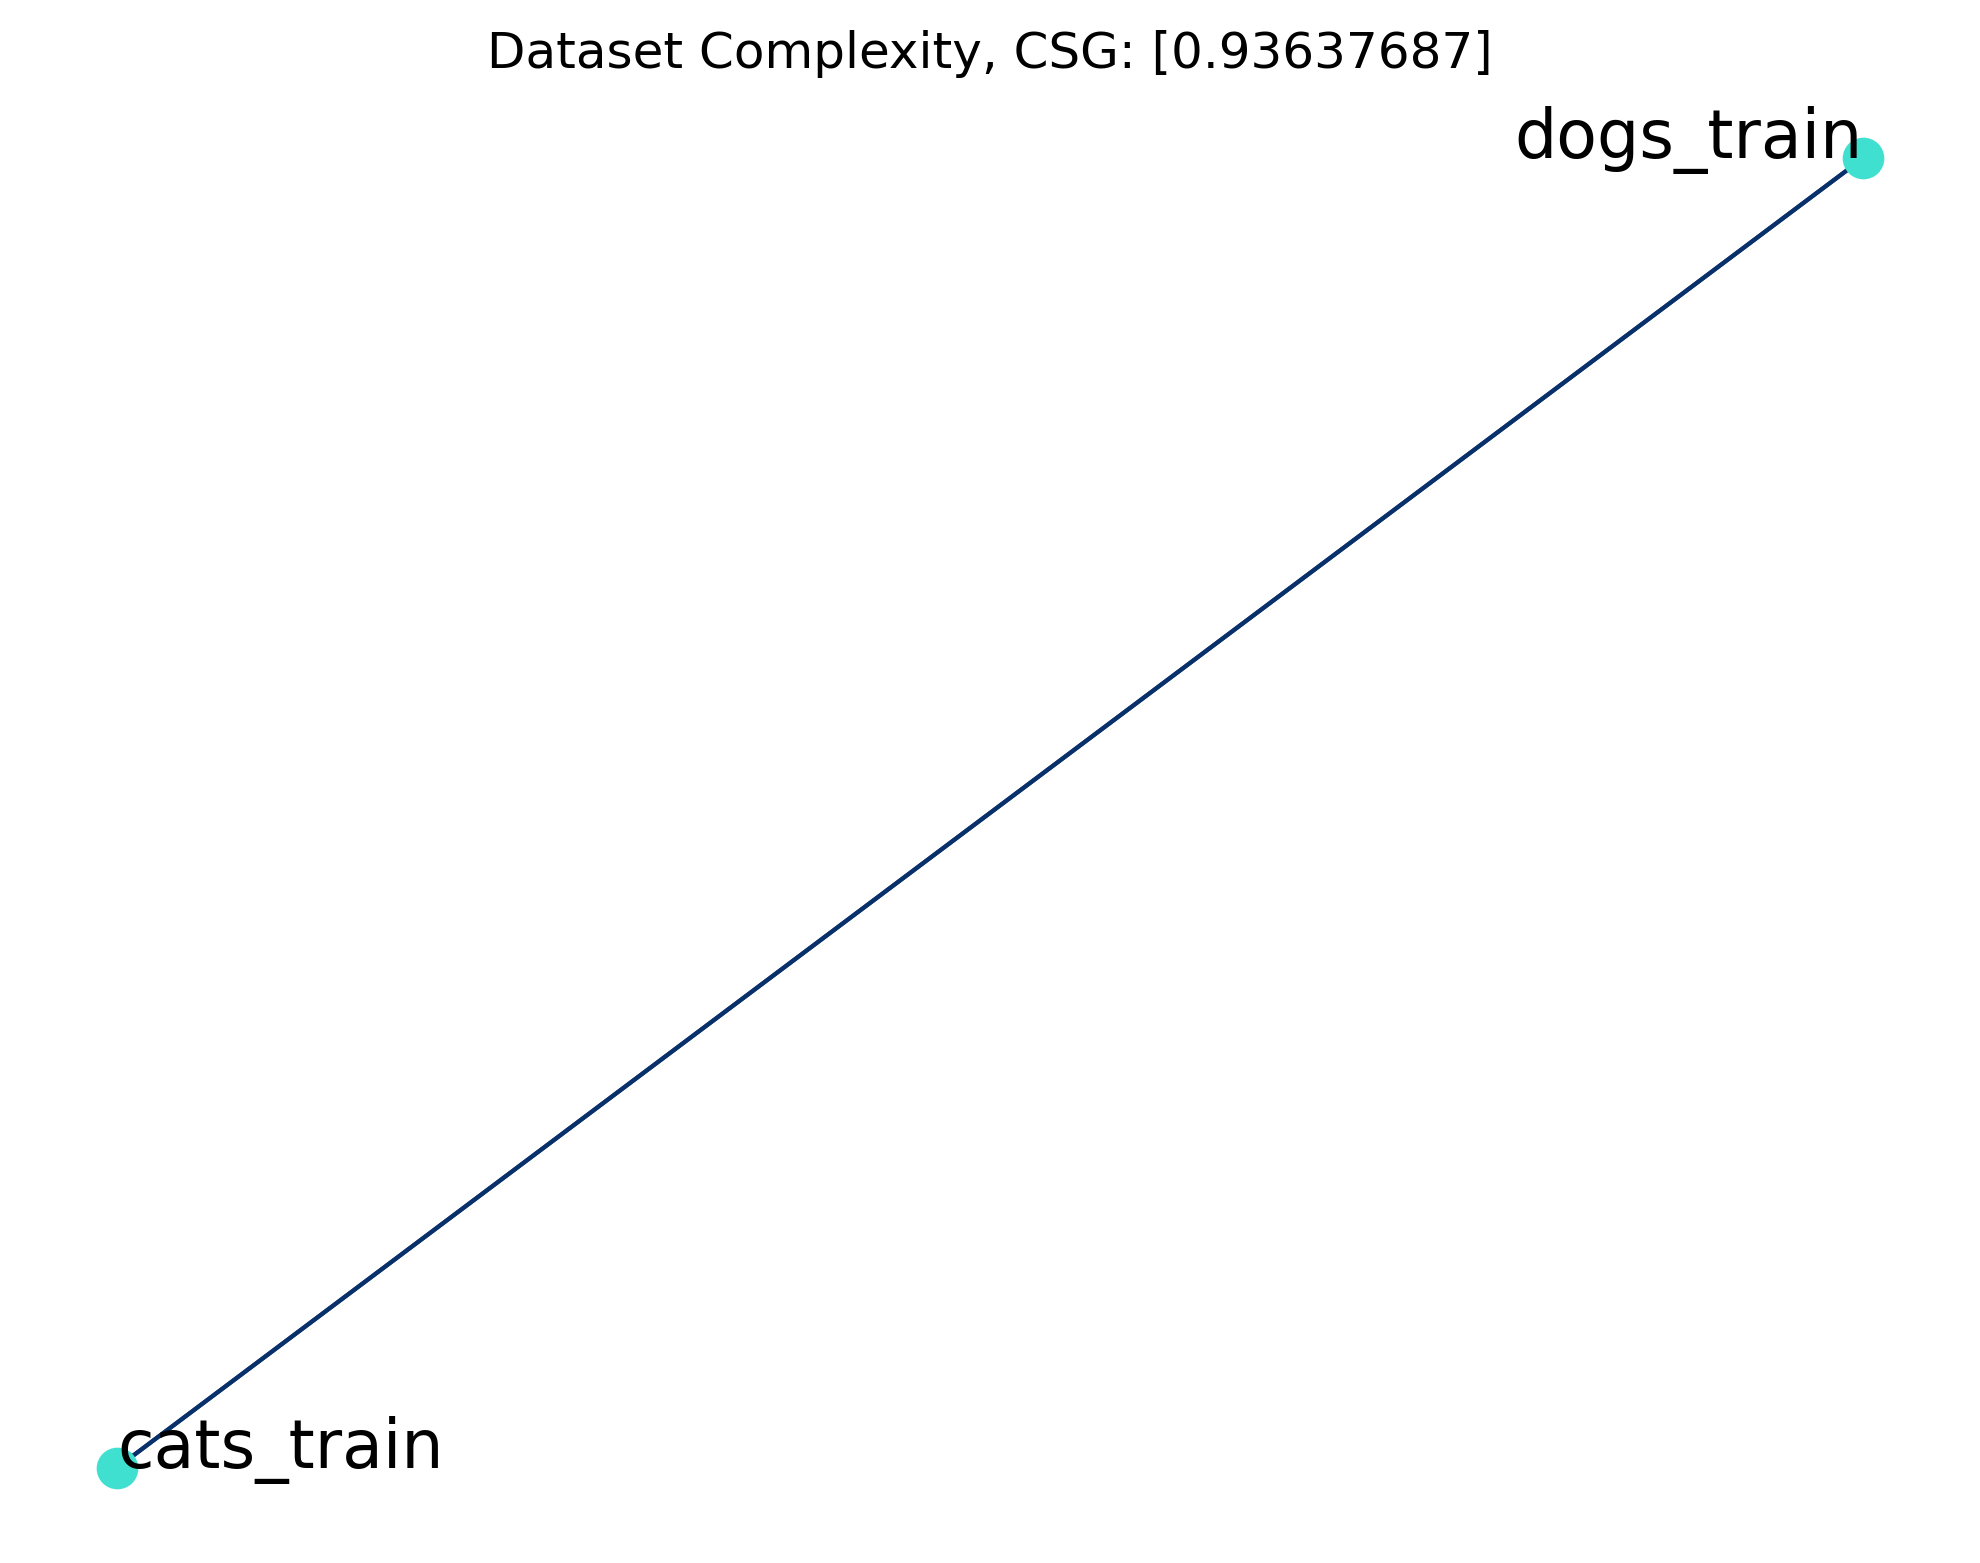

In [11]:
# Inicializar el estimador
estimator = CumulativeGradientEstimator(M_sample=557, k_nearest=10)
estimator.fit(data=fully_dataset, target=fully_labels)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Dataset Complexity, CSG: "+str(csg), classes=class_names_train)

Calcular la similitud entre clases

In [12]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(clase_i, clase_j) for clase_i, clase_j in pairs if clase_i != clase_j]


# Asegúrate de que el índice de las clases no exceda la cantidad de clases en el dataset
filtered_pairs = [(clase_i, clase_j) for clase_i, clase_j in pairs 
                  if clase_i < len(class_names_train) and clase_j < len(class_names_train)]

# Obtener el par de clases menos similares
similitud_de_clases = filtered_pairs[0]
clase_i, clase_j = similitud_de_clases

print("Cálculo de similitud entre clases")
lst = []
for idx, (clase_i, clase_j) in enumerate(filtered_pairs[::2][:1]):
    lst.append({"Clases a comparar": f"{class_names_total[clase_i]} <> {class_names_train[clase_j]}", 
                "Similitud": estimator.W[clase_i, clase_j]})

# Mostrar la similitud en un DataFrame
print(pd.DataFrame(lst))

# Mostrar las dimensiones de la matriz de similitud
print(estimator.W.shape)


Cálculo de similitud entre clases
         Clases a comparar  Similitud
0  cats_test <> dogs_train   0.936377
(2, 2)


Calcular la similitud entre muestras

In [13]:
# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_train.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f for i, f in enumerate(directorio_train.glob('*/*.png'))}


1. Visualizar las muestras (par de imagenes) menos similares entre la misma clase

Muestras menos similares entre las imágenes de la misma clase 

Clase: cats_train
	Nombre del archivo: cat_544.jpg, Clase: cats_train, Similitud: 0.0501
	Nombre del archivo: cat_224.jpg, Clase: cats_train, Similitud: 0.0501


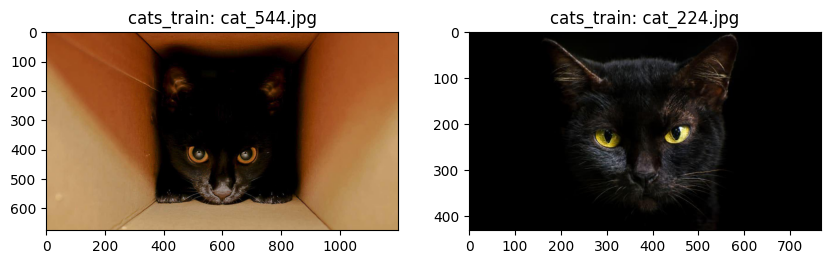

	Nombre del archivo: cat_546.jpg, Clase: cats_train, Similitud: 0.1449
	Nombre del archivo: cat_435.jpg, Clase: cats_train, Similitud: 0.1449


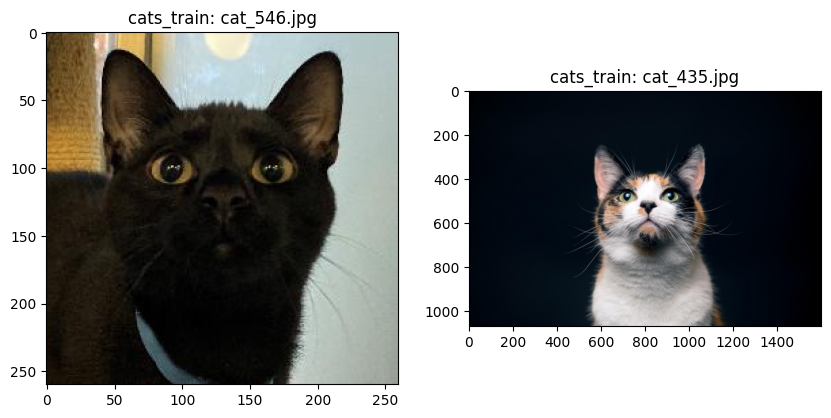

Clase: dogs_train
	Nombre del archivo: dog_509.jpg, Clase: dogs_train, Similitud: 0.1850
	Nombre del archivo: dog_505.jpg, Clase: dogs_train, Similitud: 0.1850


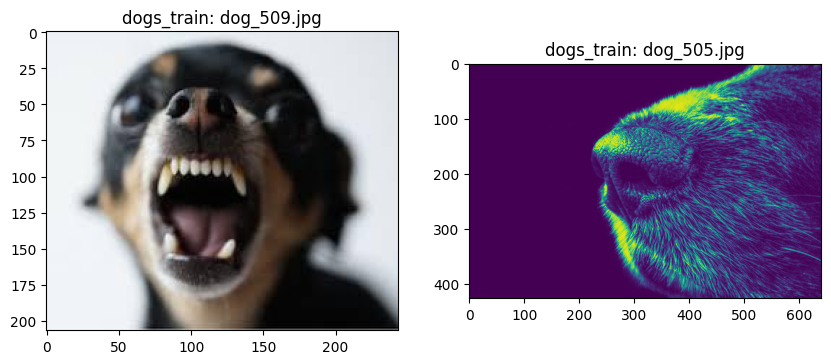

	Nombre del archivo: dog_543.jpg, Clase: dogs_train, Similitud: 0.2805
	Nombre del archivo: dog_128.jpg, Clase: dogs_train, Similitud: 0.2805


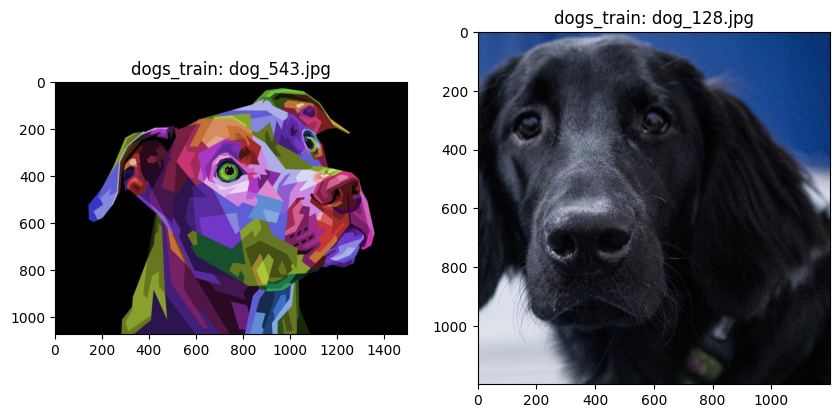

In [14]:
# Función para visualizar las imágenes menos similares dentro de cada clase usando la matriz C
def show_least_similar_using_C_all_classes(estimator, class_names, filenames_dict):
    for class_intent in range(len(class_names)):
        print(f"Clase: {class_names[class_intent]}")
        
        # Obtener la matriz de similitud de las muestras dentro de la clase
        C = estimator.C[class_intent]
        
        # Ordenar los índices según las similitudes (de menor a mayor)
        least_similar_indices = np.argsort(C, axis=None)  # No usar [::-1], para menor a mayor
        
        # Conjunto para llevar un registro de los archivos ya mostrados
        shown_files = set()
        count = 0
        show_samples = 2  # Number of samples to visualize the similarity 
        
        for idx in least_similar_indices:
            if count >= show_samples:
                break
            
            # Convertir el índice plano a índice 2D
            idx_2d = np.unravel_index(idx, C.shape)
            
            # Saltar las comparaciones de una muestra consigo misma
            if idx_2d[0] == idx_2d[1]:
                continue
            
            # Obtener los índices de las muestras en el dataset
            source_idx = estimator.class_indices[class_intent][idx_2d[0]]
            target_idx = estimator.class_indices[class_intent][idx_2d[1]]
            
            # Verificar que los índices estén dentro de los límites del dataset
            if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
                source_filename = filenames_dict[int(source_idx)]
                target_filename = filenames_dict[int(target_idx)]
                
                if source_filename not in shown_files and target_filename not in shown_files:
                    shown_files.add(source_filename)
                    shown_files.add(target_filename)
                    
                    value = C[idx_2d]
                    print(f"\tNombre del archivo: {source_filename.name}, Clase: {class_names[class_intent]}, Similitud: {value:.4f}")
                    print(f"\tNombre del archivo: {target_filename.name}, Clase: {class_names[class_intent]}, Similitud: {value:.4f}")
                    
                    img_source = plt.imread(source_filename)
                    img_target = plt.imread(target_filename)
                    
                    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                    axs[0].imshow(img_source)
                    axs[0].set_title(f"{class_names[class_intent]}: {source_filename.name}")
                    axs[1].imshow(img_target)
                    axs[1].set_title(f"{class_names[class_intent]}: {target_filename.name}")
                    plt.show()
                    
                    count += 1

print("Muestras menos similares entre las imágenes de la misma clase \n")
show_least_similar_using_C_all_classes(estimator, class_names_train, filenames_dict)


2. Visualizar las muestras (par de imagenes) menos similares entre las clases pares

Muestras menos similares entre las clases pares 

cats_train <> dogs_train
	Nombre del archivo: cat_224.jpg, Clase: cats_train, Similitud: 0.0679
	Nombre del archivo: dog_403.jpg, Clase: dogs_train, Similitud: 0.0679


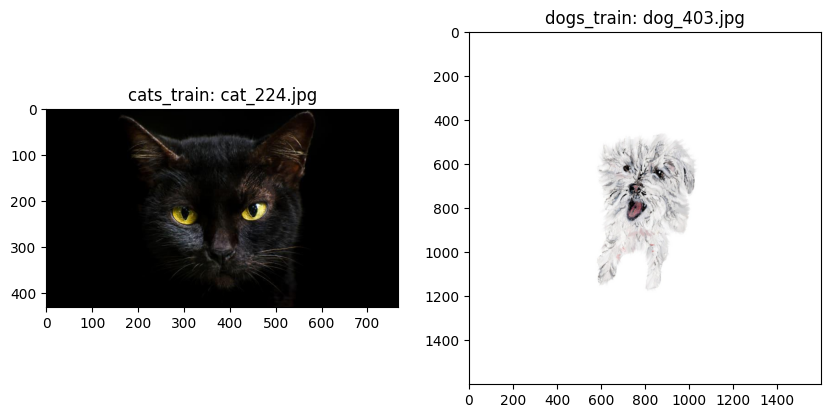

	Nombre del archivo: cat_369.jpg, Clase: cats_train, Similitud: 0.1867
	Nombre del archivo: dog_412.jpg, Clase: dogs_train, Similitud: 0.1867


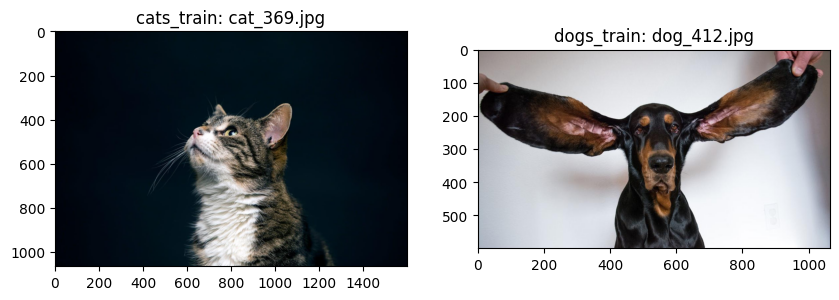

	Nombre del archivo: cat_50.jpg, Clase: cats_train, Similitud: 0.1900
	Nombre del archivo: dog_39.jpg, Clase: dogs_train, Similitud: 0.1900


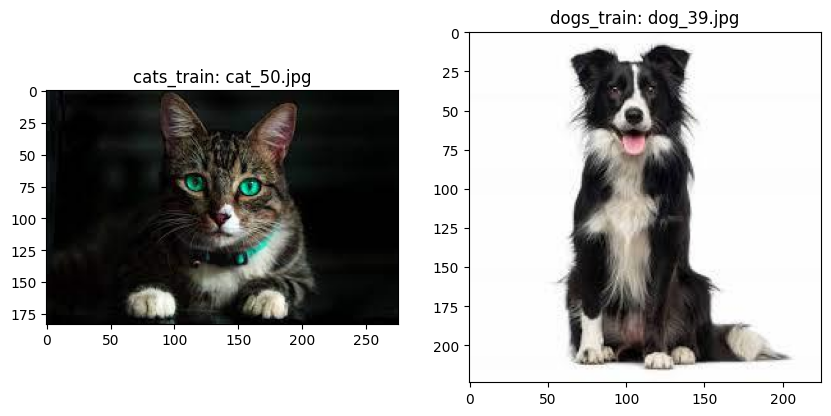

	Nombre del archivo: cat_435.jpg, Clase: cats_train, Similitud: 0.1956
	Nombre del archivo: dog_22.jpg, Clase: dogs_train, Similitud: 0.1956


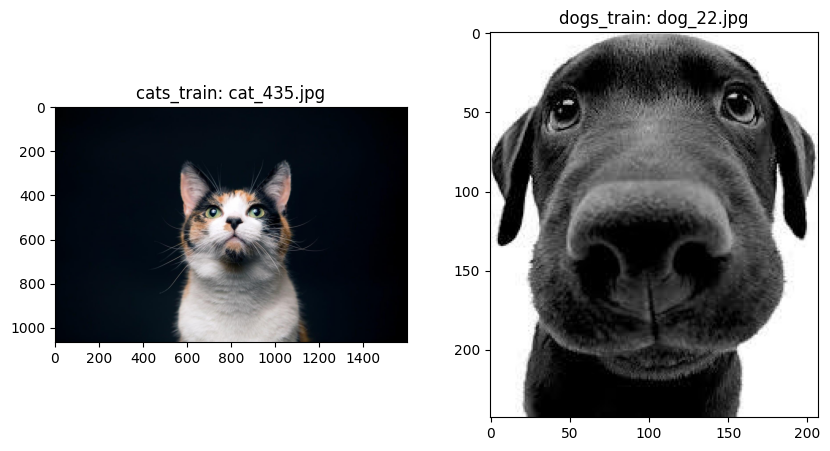

In [15]:
import itertools

# Función para visualizar las imágenes menos similares entre pares de clases usando la matriz P
def show_least_similar_using_P_all_pairs(estimator, class_names, filenames_dict):
    # Generar todas las combinaciones posibles de pares de clases
    class_pairs = list(itertools.combinations(range(len(class_names)), 2))
    
    for pair in class_pairs:
        source_intent, target_intent = pair
        print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
        
        # Obtener la matriz de similitud de las muestras entre las clases
        P = estimator.P[(source_intent, target_intent)]
        
        # Ordenar los índices según las similitudes (de menor a mayor)
        least_similar_indices = np.argsort(P, axis=None)  # No usar [::-1], para menor a mayor
        
        # Conjunto para llevar un registro de los archivos ya mostrados
        shown_files = set()
        count = 0
        show_samples = 4  # Number of samples to visualize the similarity
        
        for idx in least_similar_indices:
            if count >= show_samples:
                break
            
            # Convertir el índice plano a índice 2D
            idx_2d = np.unravel_index(idx, P.shape)
            
            # Evitar la comparación de una muestra consigo misma
            if idx_2d[0] == idx_2d[1]:
                continue
            
            # Obtener los índices de las muestras en el dataset
            source_idx = estimator.class_indices[source_intent][idx_2d[0]]
            target_idx = estimator.class_indices[target_intent][idx_2d[1]]
            
            # Verificar que los índices estén dentro de los límites del dataset
            if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
                source_filename = filenames_dict[int(source_idx)]
                target_filename = filenames_dict[int(target_idx)]
                
                if source_filename not in shown_files and target_filename not in shown_files:
                    shown_files.add(source_filename)
                    shown_files.add(target_filename)
                    
                    value = P[idx_2d]
                    print(f"\tNombre del archivo: {source_filename.name}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
                    print(f"\tNombre del archivo: {target_filename.name}, Clase: {class_names[target_intent]}, Similitud: {value:.4f}")
                    
                    img_source = plt.imread(source_filename)
                    img_target = plt.imread(target_filename)
                    
                    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                    axs[0].imshow(img_source)
                    axs[0].set_title(f"{class_names[source_intent]}: {source_filename.name}")
                    axs[1].imshow(img_target)
                    axs[1].set_title(f"{class_names[target_intent]}: {target_filename.name}")
                    plt.show()
                    
                    count += 1

print("Muestras menos similares entre las clases pares \n")
show_least_similar_using_P_all_pairs(estimator, class_names_train, filenames_dict)



3. Visualizar las muestras (par de imagenes) menos similares entre todo el dataset

	Nombre del archivo: cat_544.jpg, Similitud: 0.0501
	Nombre del archivo: cat_224.jpg, Similitud: 0.0501


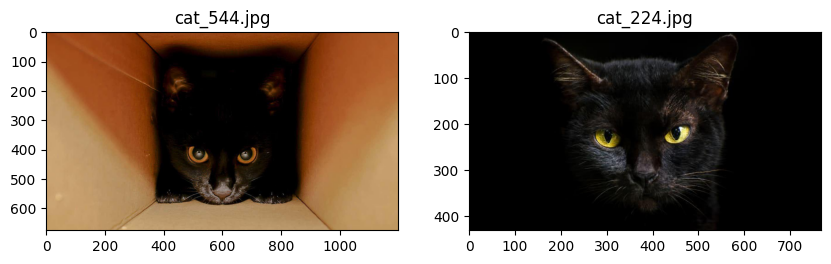

	Nombre del archivo: cat_435.jpg, Similitud: 0.1449
	Nombre del archivo: cat_546.jpg, Similitud: 0.1449


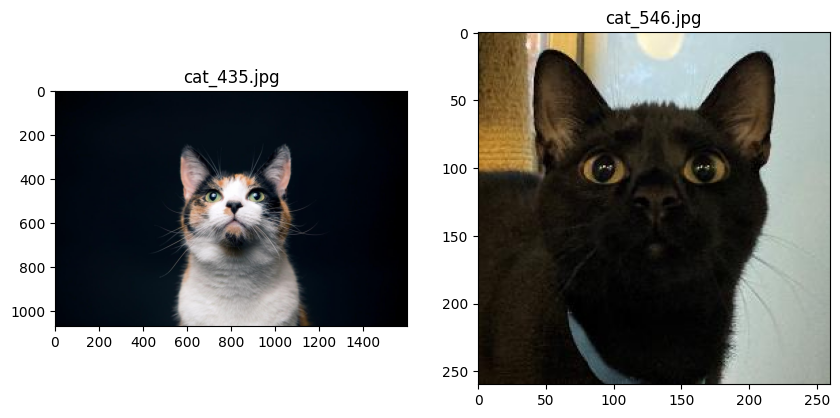

	Nombre del archivo: cat_369.jpg, Similitud: 0.1757
	Nombre del archivo: cat_327.jpg, Similitud: 0.1757


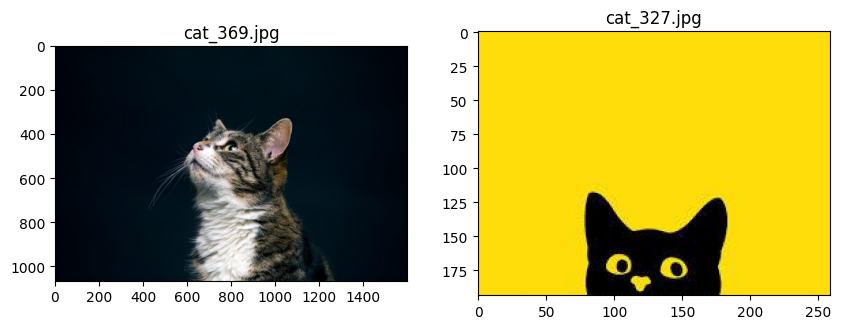

	Nombre del archivo: dog_509.jpg, Similitud: 0.1850
	Nombre del archivo: dog_505.jpg, Similitud: 0.1850


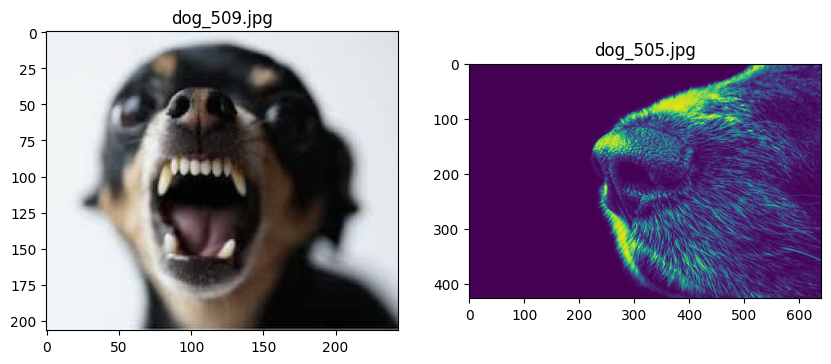

	Nombre del archivo: cat_50.jpg, Similitud: 0.1900
	Nombre del archivo: dog_39.jpg, Similitud: 0.1900


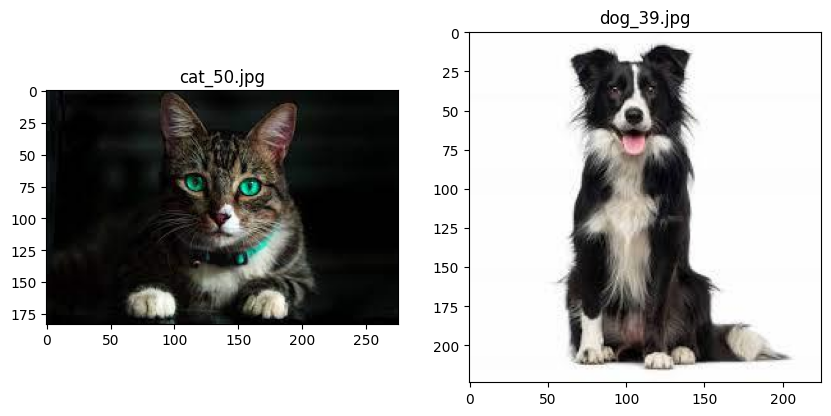

	Nombre del archivo: cat_265.jpg, Similitud: 0.2497
	Nombre del archivo: dog_543.jpg, Similitud: 0.2497


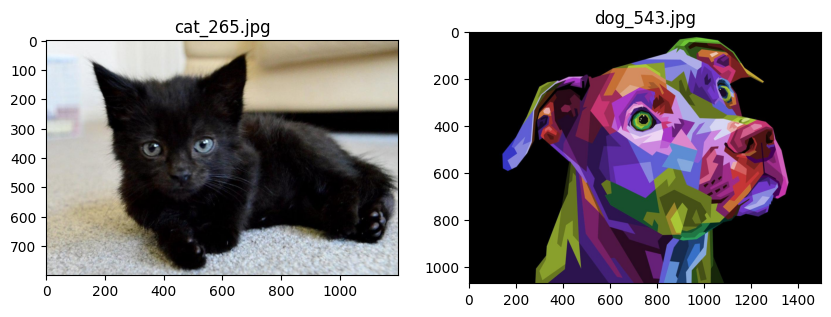

	Nombre del archivo: cat_101.jpg, Similitud: 0.2546
	Nombre del archivo: dog_403.jpg, Similitud: 0.2546


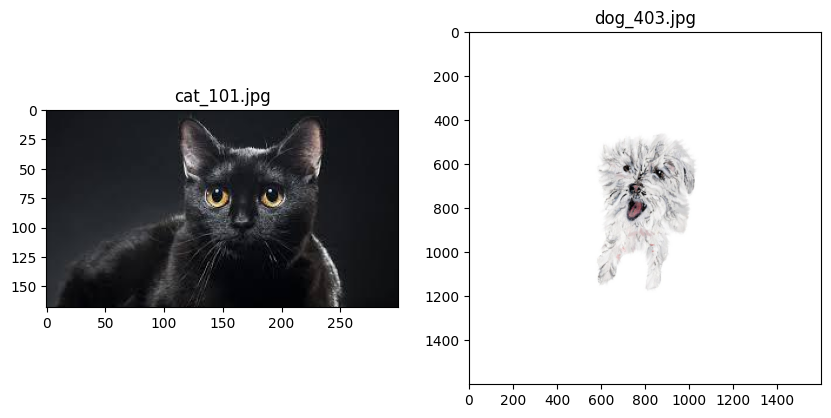

	Nombre del archivo: dog_128.jpg, Similitud: 0.2718
	Nombre del archivo: cat_303.jpg, Similitud: 0.2718


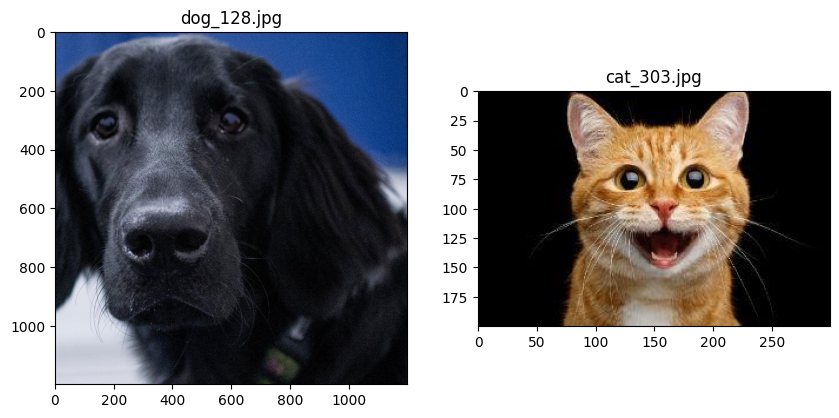

	Nombre del archivo: cat_440.jpg, Similitud: 0.2793
	Nombre del archivo: cat_518.jpg, Similitud: 0.2793


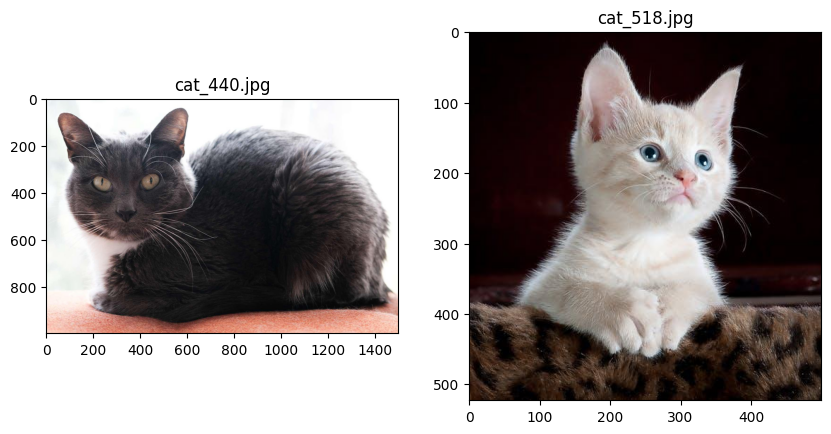

	Nombre del archivo: cat_399.jpg, Similitud: 0.3147
	Nombre del archivo: cat_420.jpg, Similitud: 0.3147


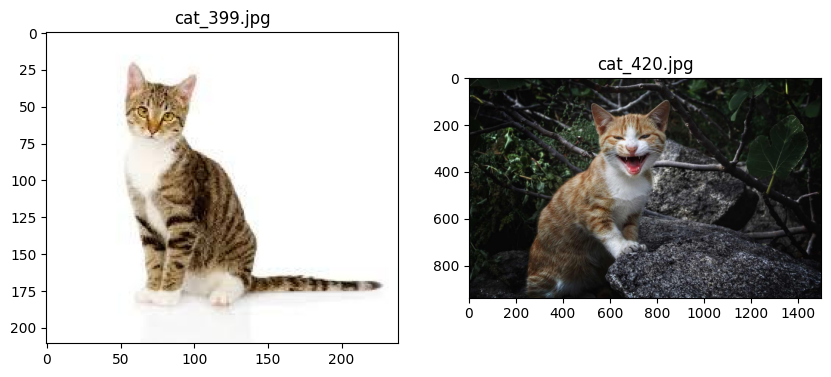

In [16]:
#Muestras menos similares utilizando la matriz M

# Acceder a la matriz M después de ajustar el modelo
M = estimator.M

# Ordenar los índices según las similitudes (de menor a mayor)
least_similar_indices = np.argsort(M, axis=None)

# Conjunto para llevar un registro de los archivos ya mostrados
shown_files = set()
count = 0
show_samples = 10  # Número de muestras a visualizar

# Mostrar las 10 muestras menos similares
for idx in least_similar_indices:
    if count >= show_samples:
        break

    # Convertir el índice plano a índice 2D
    idx_2d = np.unravel_index(idx, M.shape)

    # Obtener los índices globales de las muestras en el dataset
    source_idx = idx_2d[0]
    target_idx = idx_2d[1]

    # Verificar que los índices estén dentro de los límites del dataset
    if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
        source_filename = filenames_dict[source_idx]
        target_filename = filenames_dict[target_idx]

        # Verificar si las imágenes ya han sido mostradas (en cualquiera de los dos roles)
        if source_filename.name not in shown_files and target_filename.name not in shown_files:
            shown_files.add(source_filename.name)
            shown_files.add(target_filename.name)

            value = M[idx_2d]
            print(f"\tNombre del archivo: {source_filename.name}, Similitud: {value:.4f}")
            print(f"\tNombre del archivo: {target_filename.name}, Similitud: {value:.4f}")
            
            # Visualizar las imágenes de los pares menos similares
            img_source = plt.imread(source_filename)
            img_target = plt.imread(target_filename)
            
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(img_source)
            axs[0].set_title(f"{source_filename.name}")
            axs[1].imshow(img_target)
            axs[1].set_title(f"{target_filename.name}")
            plt.show()

            count += 1
